[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/famma-bench/bench-script/blob/main/notebooks/FAMMA_3_reasoning_inspection.ipynb)


# FAMMA‑Reasoning  
**An advanced, tool‑augmented reasoning dataset for financial Q&A**

## Dataset Overview  
FAMMA‑Reasoning extends the original [FAMMA](https://famma-bench.github.io/famma/) benchmark to provide richly annotated, high‑quality reasoning examples designed for reasoning model.

## Rich Reasoning Annotations  
Every example in FAMMA‑Reasoning is paired with two complementary reasoning artifacts, distilled from DeepSeek‑R1:

1. Thinking Trajectories: Natural‑language, step‑by‑step chains of thought that narrate the full logical journey—ideal for teaching models to “think aloud.”  

2. Structured Thinking Trajectories: Marked sequences leveraging tags like `<think>`, `<search>`, `<python>`, `<information>`, etc., which guide models to incorporate external tools and intermediate computations.

These dual annotations ensure models not only arrive at the correct answer, but also learn *how* to use search, code execution, and data lookups in a disciplined workflow.

## Provenance & Quality  
- Official FAMMA Source: All questions are drawn from FAMMA dataset those have been faithfully answered by DeepSeek‑R1.  
- Continuous Updates: New, real‑world questions from finance professionals are regularly integrated to keep the benchmark fresh and challenging.

## Getting Started  

### Download the dataset

To download the dataset, firstly we need to git clone the repository [https://github.com/famma-bench/bench-script](https://github.com/famma-bench/bench-script) and install the dependencies.




In [ ]:
! rm -rf bench-script
! git clone https://github.com/famma-bench/bench-script.git
! pip install -r bench-script/requirements.txt
! cd bench-script && pip install -e .

Finally, we can download the dataset by running the following script.

In [2]:
import sys
sys.path.append("./bench-script")

from famma_runner.utils.data_utils import download_data

# the directory of the dataset in huggingface
hf_dir = "weaverbirdllm/famma-reasoning"

# the version of the dataset, there are two versions: release_basic and release_livepro
# if None, it will download the whole dataset
split = "release_reasoning_basic_txt"

# the local directory to save the dataset
save_dir = "./data"

# whether to download the dataset from huggingface or local, by default it is False
from_local = False

success = download_data(
        hf_dir=hf_dir,
        split=split,
        save_dir=save_dir,
        from_local=from_local
    )



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.80k [00:00<?, ?B/s]

(…)asoning_basic_txt-00000-of-00001.parquet:   0%|          | 0.00/6.86M [00:00<?, ?B/s]

Generating release_reasoning_basic_txt split:   0%|          | 0/1273 [00:00<?, ? examples/s]

Saved release_reasoning_basic_txt split to ./data/release_reasoning_basic_txt.json

Dataset downloaded and saved to ./data
Images are saved in ./data/images_release_reasoning_basic_txt


After downloading, the dataset will be saved in the local directory `./data` in json format.  

# Dataset Inspection

## Dataset Statistics

We use the following script to show the overall statistics of the dataset.

In [3]:
from famma_runner.utils.descriptive_utils import get_dataset_statistics

stat_dict = get_dataset_statistics('data/release_reasoning_basic_txt.json')


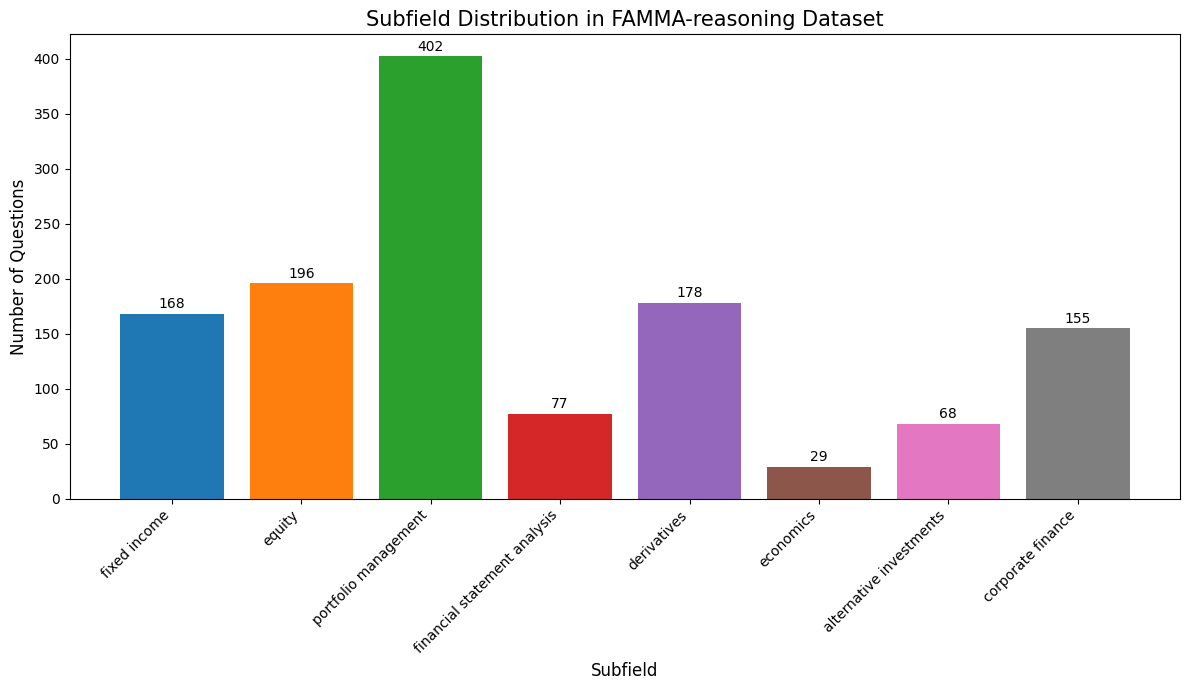

In [4]:
import matplotlib.pyplot as plt

# Create a bar plot for subfield distribution
plt.figure(figsize=(12, 7))
subfields = list(stat_dict['subfield_count'].keys())
counts = list(stat_dict['subfield_count'].values())

# Use a colorful palette for different subfields
colors = plt.cm.tab10(range(len(subfields)))
plt.bar(subfields, counts, color=colors)

plt.title('Subfield Distribution in FAMMA-reasoning Dataset', fontsize=15)
plt.xlabel('Subfield', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add count labels on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()



## Question Viewer

The following section provides a question viewer that allows us to examine the detailed content of any question in the FAMMA dataset by specifying its unique question ID. This helps us understand the structure and content of individual questions, including their context, images, and answer information.

In [7]:
data_dir = 'data/release_reasoning_basic_txt.json'
language = 'english'
main_question_id = '1'
subquestion_id = '1'

from easyllm_kit.utils import read_json
import json


def find_question(
    data_path: str,
    language: str,
    main_question_id: int | str,
    sub_question_id: int | str,
):
    """
    Return the question that matches (language, main_question_id, sub_question_id).
    Fallback logic:
        1) Try an exact match.
        2) If the sub-question ID does not exist, return the *closest* sub-question
           whose ID is smaller than the requested one (i.e., “the previous item”).
        3) If even that fails, return the first sub-question under the same main
           question ID.

    Raises
    ------
    ValueError
        If the specified main_question_id is not found for the given language.
    """
    data = read_json(data_dir)

    lang = language.lower()
    main_id = str(main_question_id)
    sub_id = str(sub_question_id)

    # 1. keep only questions in the requested language
    pool = [q for q in data if q.get("language", "").lower() == lang]

    # 2. keep only questions with the requested main_question_id
    same_main = [q for q in pool if str(q.get("main_question_id")) == main_id]
    if not same_main:
        raise ValueError(f"main_question_id={main_id} not found for language={language}")

    # 3. exact match
    for q in same_main:
        if str(q.get("sub_question_id")) == sub_id:
            return q

    # 4. fallback: previous sub_question_id (largest id that is < target)
    try:
        target = int(sub_id)
        smaller = [q for q in same_main if int(q["sub_question_id"]) < target]
        if smaller:
            return max(smaller, key=lambda x: int(x["sub_question_id"]))
    except ValueError:
        # sub_id is not numeric -> skip numeric fallback
        pass

    # 5. final fallback: return the first sub-question under this main ID
    return min(same_main, key=lambda x: int(x["sub_question_id"]))


q = find_question(
    data_path=data_dir,
    language=language,
    main_question_id=main_question_id,
    sub_question_id=subquestion_id,   # if “3” is missing it will fall back to 2 → 1
)

print(q["question_id"])
print(q["source_release"])
print(q["context"])
print(q["question"])
print(q["options"])
print(q["answers"])
print(q["thinking_trajectory"])
print(q["structured_thinking_trajectory"])


english_1_1_r3
release_basic_txt
Below image is a sceenshot of the Contract specifications for a puttable floating rate note issued by the Korea Development from Bloomberg. <image_1>
Bank. /n <ocr>image_1 ocr text: DES DL17CORP DES Enter 10 <Go>forNews,11 <Go>for Involved Parties SECURITY DISPLAY PAGE1/ 6 KOREA DEV BANK KDBF1oat06/02 NOT PRICED ISSUER INFORMATION SECURITY INFORMATION SERIES: EMTN NAME KOREA DEVELOPMENT BANK NOT SEASONED TYPE BANK CPN FREQ QUARTLY IDENTIFICATION #'s REDEMPTION INFO CPN TYPE FLOATING ISIN XS0077584307 MATURITY DT 6/30/ 2 MTY/REFUND TYP CALL/PUT MLNUM FDLD9 REFUNDING DT CALC TYP21)FLOATRATENOTE NEXT CALL DT 6/30/0 DAYCOUNT2ACT/360 COMMON 007758430 WORKOUT DT 6/30/ 2 MARKET ISS EURO MTN RISK FACTOR COUNTRY/CURR S.K./USD ISSUANCE INFO COLLATERAL TYP SR UNSUB ANNOUNCE DT 6/16/97 RATINGS AMT ISSUED 300000M 1ST SETTLE DT 6/30/97 300,000(M) MOODY Baa2/*- AMT OUTSTAND 1ST CPN DT 9/30/97 MIN PC/INC S&P A- /*- 10,000/10,000 INTACCRUE DT6/30/97 COMP BBB1 PAR AMT 10